# **Advanced Artificial Intelligence Coursework - Aida Ovalle Filippova (2006512)**

---



## **Section 1 : Dataset**

---



The IMDB Movie Review dataset is a popular dataset used for sentiment analysis, with 50.000 reviews labelled as either "positive" or "negative". There is an equal number of reviews for each class.

In this project, the goal is to build a system that can predict the sentiment of a review based on the text. This is quite common for an NLP task and it's useful for real applications such as analysing customer feedback, product reviews, or social media comments. Using NLP will automate the process of understanding large amounts of text, which would take a long time to analyse manually.

Dataset Link: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download

Paper Link: https://arxiv.org/pdf/1412.1058v2

In [1]:
#Environment Setup (Only run if Gensim or Numpy throws errors)

INSTALL_DEPENDENCIES = False  #Set to True ONLY if packages are missing or broken

if INSTALL_DEPENDENCIES:
    !pip install --no-cache-dir gensim==4.3.1 numpy==1.23.5 scipy==1.10.1
    !pip install tensorflow==2.12.0

"""
NOTES:
This notebook has been tested with:
- gensim==4.3.1
- numpy==1.23.5
- scipy==1.10.1

If you see an error like:
    ValueError: numpy.dtype size changed...
Then:
1. Set INSTALL_DEPENDENCIES = True
2. Run this cell
3. Restart the runtime
4. Set INSTALL_DEPENDENCIES = False again
5. Run all cells from the top
"""


'\nNOTES:\nThis notebook has been tested with:\n- gensim==4.3.1\n- numpy==1.23.5\n- scipy==1.10.1\n\nIf you see an error like:\n    ValueError: numpy.dtype size changed...\nThen:\n1. Set INSTALL_DEPENDENCIES = True\n2. Run this cell\n3. Restart the runtime\n4. Set INSTALL_DEPENDENCIES = False again\n5. Run all cells from the top\n'

In [2]:
#Test environment setup
try:
    import gensim
    import numpy as np
    print("Setup successful: gensim and numpy are ready to use.")
except Exception as e:
    print("Setup issue:", e)


Setup successful: gensim and numpy are ready to use.


In [3]:
#Load the dataset
import pandas as pd
import numpy as np
import io
from google.colab import files

df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


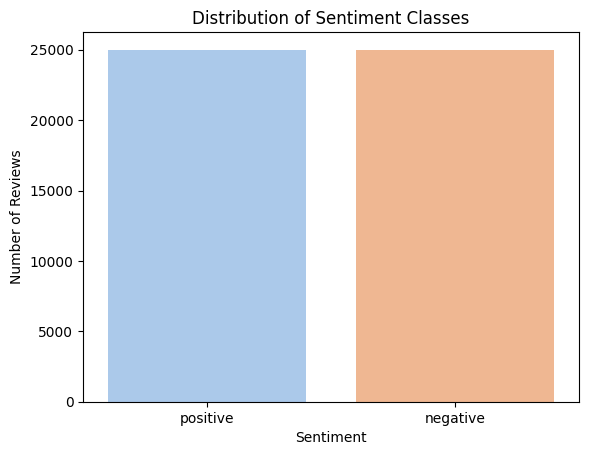

In [4]:
#Check the Class Distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x="sentiment", hue="sentiment", palette="pastel")
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

The Class Distribution plot above shows that the dataset is evenly split between positive and negative reviews, with no class bias.

To begin exploration, the average review length (in words) is analysed to understand the distribution of input sizes, and it is seen that most reviews are less than 500 words.

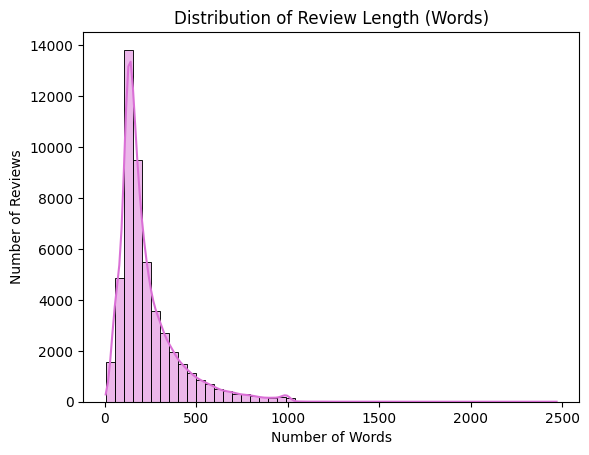

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


In [5]:
#Check the average review length

#New column for review length
df["review_length"] = df["review"].apply(lambda x: len(x.split()))

sns.histplot(df["review_length"], bins=50, kde=True, color="orchid")
plt.title("Distribution of Review Length (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

df.head()

Finding out the most common words for each class is useful, as it would allow non-essential words to be removed and stop impacting the class distribution.

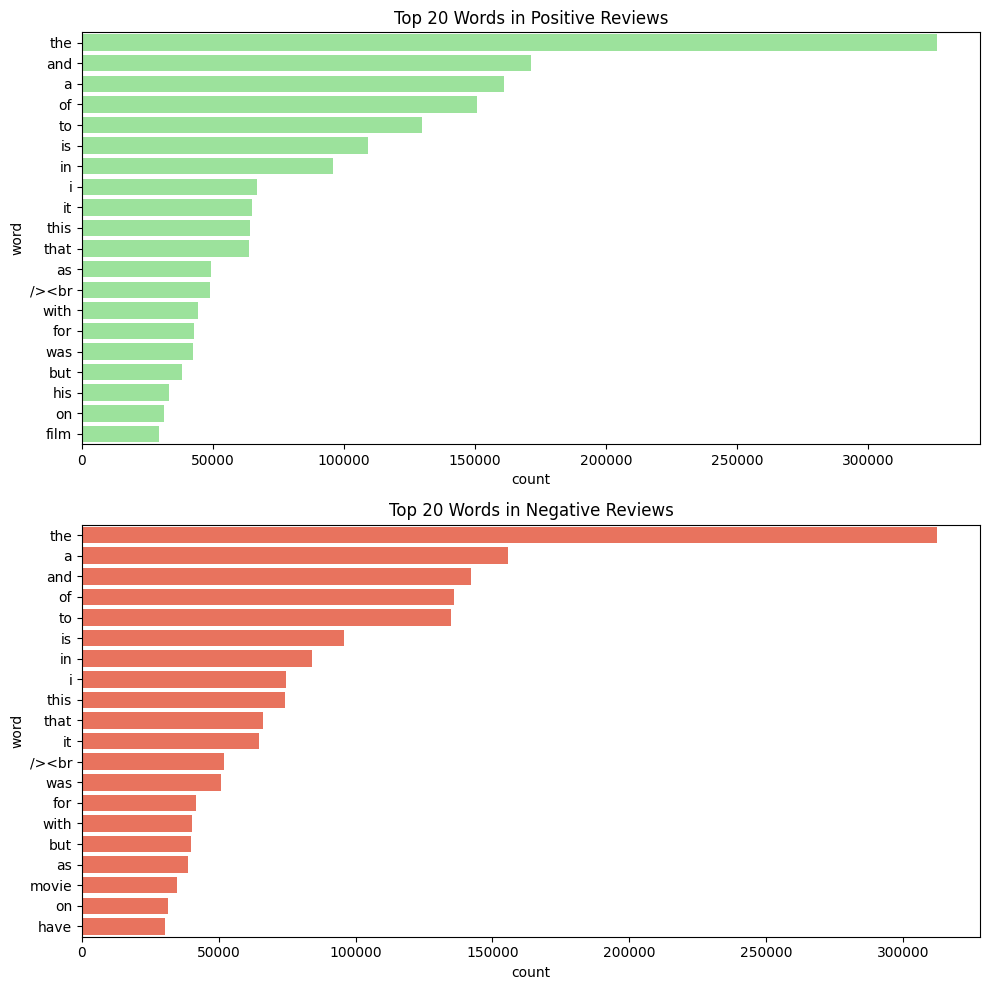

In [6]:
#Check Top Words per Sentiment Class

#Separate positive and negative reviews
positive_reviews = df[df["sentiment"] == "positive"]
negative_reviews = df[df["sentiment"] == "negative"]

#Tokenize each review into words
positive_words = " ".join(positive_reviews["review"]).lower().split()
negative_words = " ".join(negative_reviews["review"]).lower().split()

#Get 20 most common words in each
from collections import Counter
top_positive = Counter(positive_words).most_common(20)
top_negative = Counter(negative_words).most_common(20)

#Convert to a Data Frame for plotting
top_positive_df = pd.DataFrame(top_positive, columns=["word", "count"])
top_negative_df = pd.DataFrame(top_negative, columns=["word", "count"])

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(data=top_positive_df, x="count", y="word", ax=axes[0], color="lightgreen")
axes[0].set_title("Top 20 Words in Positive Reviews")

sns.barplot(data=top_negative_df, x="count", y="word", ax=axes[1], color="tomato")
axes[1].set_title("Top 20 Words in Negative Reviews")

plt.tight_layout()
plt.show()


The most common words across both classes are meaningless, so these should be removed, along with the basic stopwords.

In [7]:
#Preprocessing

import re
import string
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

#Stopword list
custom_stopwords = set(["film", "movie"])
all_stopwords = set(stopwords.words("english")).union(custom_stopwords)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<br\s*/?>", " ", text)  #Remove <br>, <br/>, <br />
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  #Get rid of punctuation
    words = text.split()
    words = [word for word in words if word not in all_stopwords]  #Remove all stopwords
    return " ".join(words)

#Apply data cleaning
df["clean_review"] = df["review"].apply(clean_text)
df["clean_tokens"] = df["clean_review"].apply(lambda x: x.split())

df[["review", "clean_review"]].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


To see the effect of the cleaning, the top words per Sentiment Class should be checked again. Also, Stemming or Lemmatisation are good ways of making the data easier to work with, since it shortens words to their basic form.

A sample of the processed data is displayed after this code block to check the impact of preprocessing.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


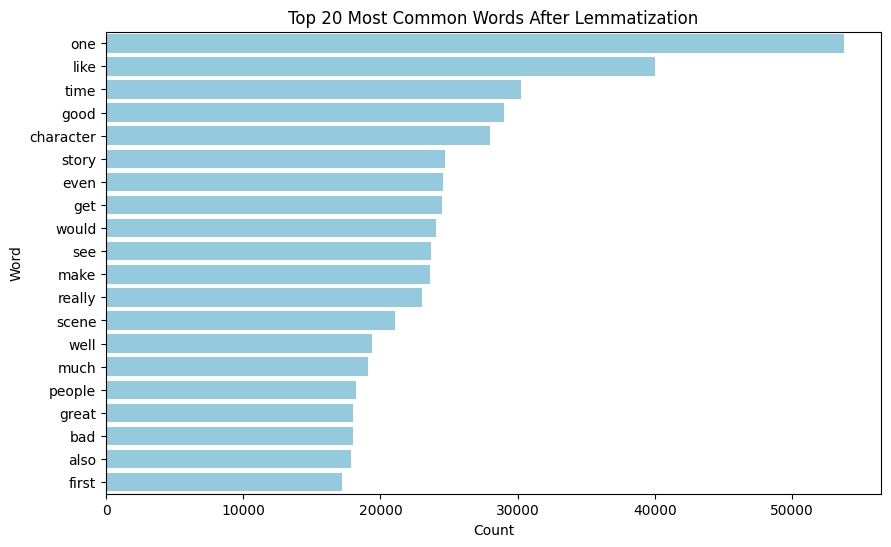

,review,clean_review,lemmatized_review
7481,i say the domino principle is an enormously un...,say domino principle enormously underappreciat...,say domino principle enormously underappreciat...
37058,"You got to love this movie! I mean, what other...",got love mean swedish splatter could evil biza...,got love mean swedish splatter could evil biza...
17379,Using footage pillaged from Planet of Dinosaur...,using footage pillaged planet dinosaurs shot v...,using footage pillaged planet dinosaur shot vi...


In [8]:
#Lemmatisation (Makes data more readable than Stemming)
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# Apply lemmatisation
df["lemmatized_tokens"] = df["clean_tokens"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df["lemmatized_review"] = df["lemmatized_tokens"].apply(lambda tokens: " ".join(tokens))


#Re-check Top Words after cleaning
from collections import Counter

#Flatten the list of all words
lemmatized_words = [word for review in df["lemmatized_tokens"] for word in review]
top_lemmatized = Counter(lemmatized_words).most_common(20)
top_lemmatized_df = pd.DataFrame(top_lemmatized, columns=["word", "count"])

#Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_lemmatized_df, x="count", y="word", color="skyblue")
plt.title("Top 20 Most Common Words After Lemmatization")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

df[["review", "clean_review", "lemmatized_review"]].sample(3)


## **Section 2 : Representation Learning**

---



This section includes common techniques in NLP that will convert text data into numbers, so that in later sections the models can work with it. The methods chosen have been Word2Vec and TF-IDF Vectorisation.

* TF-IDF (Term Frequency - Inverse Document Frequency) transforms each review into a numerical vector, based on how important each word is in the dataset. The top 10.000 most relevant words were chosen, to simplify the process. The result of this technique doesn't rely on word order.

* Word2Vec (SkipGram model) was trained on the lemmatised tokens to learn a 100-dimensional vector representation for each word. To represent each review, the vectors of its words were averaged, so that the semantics are captured.




In [9]:
#Representation Learning
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

#Downsample dataset and shuffle rows for balance
df_size = 10000
df_sampled = df.groupby("sentiment", group_keys=False).apply(lambda x: x.sample(df_size // 2, random_state=42)).reset_index(drop=True)
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

#Prepare lemmatised tokens into string format for TF-IDF
df_sampled["lemmatized_review"] = df_sampled["lemmatized_tokens"].apply(lambda x: " ".join(x))

#TF-IDF Vectorization (strings to vectors of numbers)
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df_sampled["lemmatized_review"])
X_tfidf = X_tfidf.toarray()

#Convert sentiment to binary (1;positive, 0;negative)
sentiment_labels = {"positive": 1, "negative": 0}
y = df_sampled["sentiment"].map(sentiment_labels).values

#Word2Vec (SkipGram model)
w2v_model = Word2Vec(
    sentences=df_sampled["lemmatized_tokens"],
    vector_size=100,
    window=5, #Looks for context
    min_count=2,
    workers=4,
    sg=1
)

#Function to get the average vector per review
def get_average_vector(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean([model.wv[token] for token in valid_tokens], axis=0)

X_w2v = np.array([get_average_vector(tokens, w2v_model, 100) for tokens in df_sampled["lemmatized_tokens"]])

#Shapes
print("TF-IDF shape:", X_tfidf.shape)
print("Word2Vec shape:", X_w2v.shape)
print("Labels shape:", y.shape)

df_sampled["sentiment"].value_counts()



/tmp/ipython-input-1172577948.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby("sentiment", group_keys=False).apply(lambda x: x.sample(df_size // 2, random_state=42)).reset_index(drop=True)


TF-IDF shape: (10000, 10000)
Word2Vec shape: (10000, 100)
Labels shape: (10000,)


,count
sentiment,
positive,5000
negative,5000


## **Section 3 : Algorithms**

---



For this sentiment classification task, two machine learning algorithms were implemented and evaluated: Multinomial Naive Bayes and Support Vector Machine (SVM). Both models were trained using two types of feature representations from the previous section; TF-IDF vectors and Word2Vec embeddings.

**Naive Bayes (TF-IDF):**

Multinomial Naive Bayes is a probabilistic classifier based on Bayes' Theorem, which assumes conditional independence between features. Despite its simplicity, Naive Bayes is really effective, especially in NLP tasks with large datasets. It calculates the likelihood of each sentiment class based on the input features (words in the review) and assigns the class with the highest predicted probability.

In the implementation, the Naive Bayes model was trained on TF-IDF vectors, which represent each review as a numerical vector weighted by the importance of each term in relation to the entire dataset. This representation captures not just the frequency of words but also their relevance across the dataset. By combining Naive Bayes with TF-IDF, the model benefits from the simplicity of probabilistic classification while incorporating a meaningful weighting scheme for textual features.


**Support Vector Machine (TF-IDF and Word2Vec):**

Support Vector Machines are strong classifiers that aim to find the optimal hyperplane that separates data points of different classes with the widest margin possible. They are especially useful for high dimensional data like text. SVMs also avoid overfitting and perform well even when there are more features than data samples.

In this project, two SVM models were implemented using different input features:

1. SVM with TF-IDF:
This model was trained
using the same TF-IDF feature matrix used with Naive Bayes. The high dimensional representation allows the SVM to find minor differences between classes based on the presence and weighting of key terms.

2. SVM with Word2Vec:
Here, the model was trained on dense, low dimensional semantic vectors generated from Word2Vec embeddings. Each review was represented as the mean of the word vectors for all tokens in the review. This method captures both the contextual and semantic relationships between words, offering a more detailed representation to the "meaning" than TF-IDF.

All models were evaluated using the same 80/20 train-test split, and their performance was measured using Accuracy, Precision, Recall, F1-Score, and Training Time. The results were collected into a table for analysis in the following section.

In [10]:
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd


#Use existing vector representations from Section 2
#Train, test split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

results = []

#Naive Bayes (TF-IDF)
start_time = time.time()
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
results.append({
    "Model": "Naive Bayes (TF-IDF)",
    "Accuracy": accuracy_score(y_test, y_pred_nb),
    "Precision": precision_score(y_test, y_pred_nb),
    "Recall": recall_score(y_test, y_pred_nb),
    "F1-Score": f1_score(y_test, y_pred_nb),
    "Training Time (s)": time.time() - start_time
})

#SVM (TF-IDF)
start_time = time.time()
svm_tfidf = LinearSVC()
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
results.append({
    "Model": "SVM (TF-IDF)",
    "Accuracy": accuracy_score(y_test, y_pred_svm_tfidf),
    "Precision": precision_score(y_test, y_pred_svm_tfidf),
    "Recall": recall_score(y_test, y_pred_svm_tfidf),
    "F1-Score": f1_score(y_test, y_pred_svm_tfidf),
    "Training Time (s)": time.time() - start_time
})

#SVM (Word2Vec)
start_time = time.time()
svm_w2v = LinearSVC()
svm_w2v.fit(X_train_w2v, y_train)
y_pred_svm_w2v = svm_w2v.predict(X_test_w2v)
results.append({
    "Model": "SVM (Word2Vec)",
    "Accuracy": accuracy_score(y_test, y_pred_svm_w2v),
    "Precision": precision_score(y_test, y_pred_svm_w2v),
    "Recall": recall_score(y_test, y_pred_svm_w2v),
    "F1-Score": f1_score(y_test, y_pred_svm_w2v),
    "Training Time (s)": time.time() - start_time
})

#Results Table
results_df = pd.DataFrame(results)
results_df[["Accuracy", "Precision", "Recall", "F1-Score"]] = results_df[["Accuracy", "Precision", "Recall", "F1-Score"]].round(4)
print(results_df)


                  Model  Accuracy  Precision  Recall  F1-Score  \
0  Naive Bayes (TF-IDF)     0.861     0.8681  0.8470    0.8574   
1          SVM (TF-IDF)     0.884     0.8832  0.8815    0.8824   
2        SVM (Word2Vec)     0.867     0.8609  0.8713    0.8661   

   Training Time (s)  
0           0.195757  
1           0.750221  
2           0.320733  


## **Section 4 : Evaluation**

---



To assess the performance of the implemented NLP models, several evaluation metrics were used: Accuracy, Precision, Recall, F1-Score, and Training Time. These metrics were selected to provide a comprehensive understanding of model performance on the binary sentiment classification task.

The results showed that SVM with TF-IDF achieved the highest overall performance, with an accuracy of 88.4% and an F1-Score of 88.2%. This indicates a strong ability to correctly classify both positive and negative reviews while maintaining a balance between precision and recall.

SVM with Word2Vec also performed well, achieving a slightly lower accuracy of 86.7%, but with a higher recall (87.1%) than SVM with TF-IDF. This suggests that it was more sensitive in identifying positive sentiments.

The Naive Bayes model, while slightly lower in accuracy (86.1%), showed a good performance with fast training time. This model tends to rely heavily on word frequency and might be less sensitive to contextual meaning. This could explain its slightly lower recall compared to the SVM models, especially in detecting precise sentiment expressions.

In addition to the numerical evaluation, confusion matrices were plotted to identify classification patterns and errors, and a bar chart shows the comparison of the metric performance.

Overall, SVM with TF-IDF has the most balanced and accurate sentiment classification for this scenario.

In [11]:
from sklearn.metrics import roc_auc_score

#ROC-AUC scores
roc_nb = roc_auc_score(y_test, nb.predict_proba(X_test_tfidf)[:,1])
roc_svm_tfidf = roc_auc_score(y_test, svm_tfidf.decision_function(X_test_tfidf))
roc_svm_w2v = roc_auc_score(y_test, svm_w2v.decision_function(X_test_w2v))

print("ROC-AUC Scores:")
print("Naive Bayes (TF-IDF):", round(roc_nb, 4))
print("SVM (TF-IDF):", round(roc_svm_tfidf, 4))
print("SVM (Word2Vec):", round(roc_svm_w2v, 4))
print("--------------------------------------")


ROC-AUC Scores:
Naive Bayes (TF-IDF): 0.9398
SVM (TF-IDF): 0.9512
SVM (Word2Vec): 0.9361
--------------------------------------


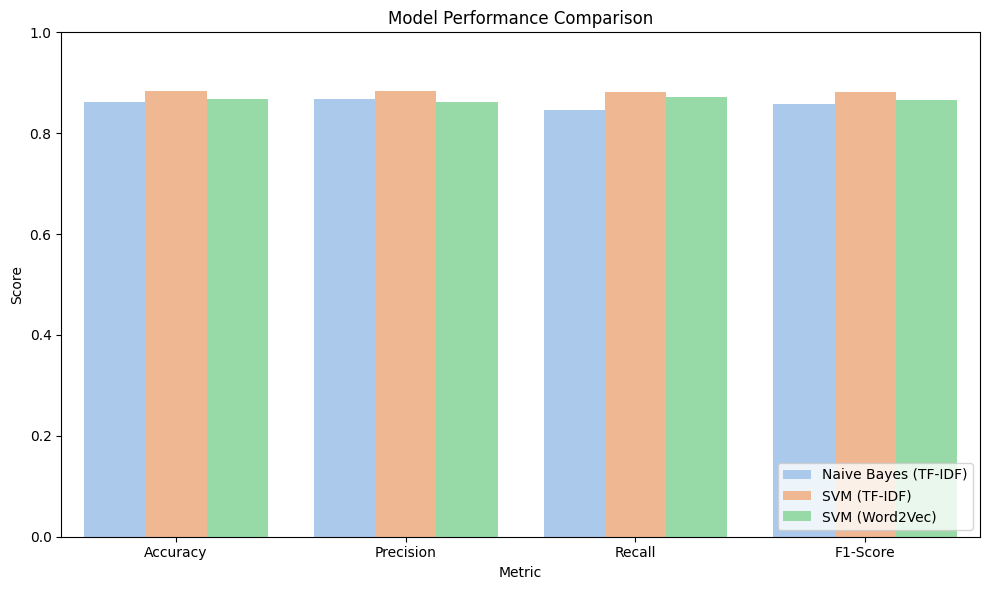

In [12]:
#Bar chart of all metrics
import seaborn as sns
import matplotlib.pyplot as plt

results_df_plot = results_df.melt(id_vars='Model', value_vars=["Accuracy", "Precision", "Recall", "F1-Score"],
                                  var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(data=results_df_plot, x='Metric', y='Score', hue='Model', palette='pastel')
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


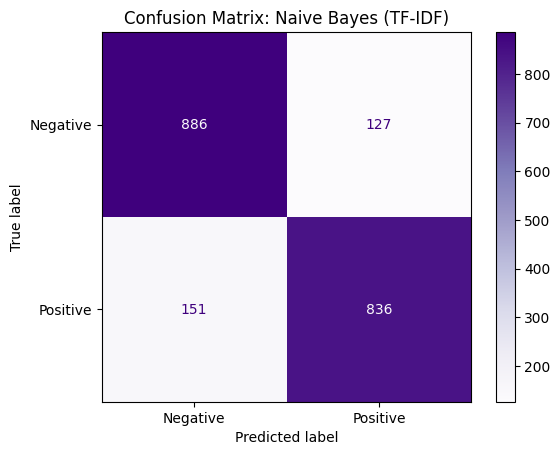

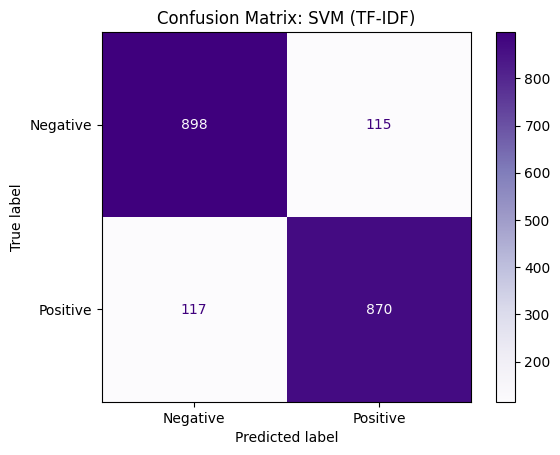

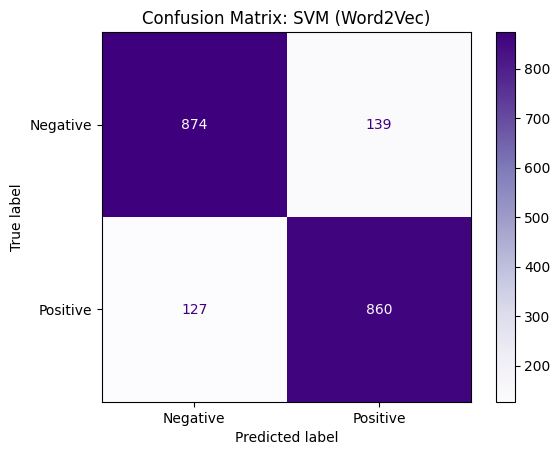

In [13]:
#Confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = {
    "Naive Bayes (TF-IDF)": (y_test, y_pred_nb),
    "SVM (TF-IDF)": (y_test, y_pred_svm_tfidf),
    "SVM (Word2Vec)": (y_test, y_pred_svm_w2v)
}

for model_name, (true, pred) in models.items():
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Purples')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()


## **Section 5 : Paper Overview**

---



The paper "Effective Use of Word Order for Text Categorization with Convolutional Neural Networks", by Rie Johnson and Tong Zhang, presents a new approach to text categorisation, which involves assigning predefined categories to natural language documents. This includes tasks such as topic classification (politics, sports) and sentiment classification (positive or negative reviews).

Traditional models for text classification often use Bag of Words (BoW) or n-gram features, but they don't take word order into account. This can be a problem, especially for sentiment analysis, because the order of words plays a critical role in the meaning of the sentence (e.g., “not good” vs “good”). While n-grams attempt to include some sequential context, they often make the data sparse and are less efficient.

The paper introduces a new method that applies Convolutional Neural Networks (CNNs) directly to high-dimensional one-hot encoded text data, without using pre-trained word embeddings. It proposes two main CNN variants:

* seq-CNN; which uses sequential word windows and preserves word order;

* bow-CNN; which applies bag of words methods within convolutional windows to reduce dimensionality.

Additionally, the authors explore parallel CNNs to combine different types of region embeddings, and introduce a dynamic pooling strategy for handling texts with variable length.

The authors demonstrate the effectiveness of their approach using multiple datasets. Interestingly, seq-CNN achieves top results for sentiment classification tasks (IMDB, Elec), while bow-CNN performs better on topic classification (RCV1). Their findings show that CNNs can successfully use word order, outperforming traditional BoW based models and shallow learning algorithms.

## **Section 6 : Algorithms from Paper**

---



In [46]:
#Implement the algorithm as described in the paper

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_sampled["clean_review"])
sequences = tokenizer.texts_to_sequences(df_sampled["clean_review"])
X_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')
y_seq = df_sampled["sentiment"].map({"positive": 1, "negative": 0}).values


The block above converts each review into a sequence of integers and pads them to the same length.


In [47]:
#Training and testing sets (80% train, 20% test).
from sklearn.model_selection import train_test_split

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)


The block below creates a CNN model that classifies sentiment by using word embeddings, convolution, pooling, and dense layers.


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

vocab_size = 10000
embedding_dim = 100
input_length = 500

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    Conv1D(filters=250, kernel_size=3, activation='relu'),  #Sequence Based CNN
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  #Binary Classification
])


The model is trained for 5 epochs using the training data, showing the accuracy of each epoch.


In [49]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/5
100/100 [==============================] - 40s 389ms/step - loss: 0.6451 - accuracy: 0.6177 - val_loss: 0.4996 - val_accuracy: 0.7719
Epoch 2/5
100/100 [==============================] - 38s 381ms/step - loss: 0.3785 - accuracy: 0.8348 - val_loss: 0.3559 - val_accuracy: 0.8469
Epoch 3/5
100/100 [==============================] - 36s 359ms/step - loss: 0.1978 - accuracy: 0.9278 - val_loss: 0.3729 - val_accuracy: 0.8438
Epoch 4/5
100/100 [==============================] - 36s 358ms/step - loss: 0.0827 - accuracy: 0.9741 - val_loss: 0.4426 - val_accuracy: 0.8475
Epoch 5/5
100/100 [==============================] - 36s 358ms/step - loss: 0.0387 - accuracy: 0.9878 - val_loss: 0.5676 - val_accuracy: 0.8331


In [50]:
loss, accuracy = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8355


The graph below show the training and validation accuracy across epochs to check for overfitting.

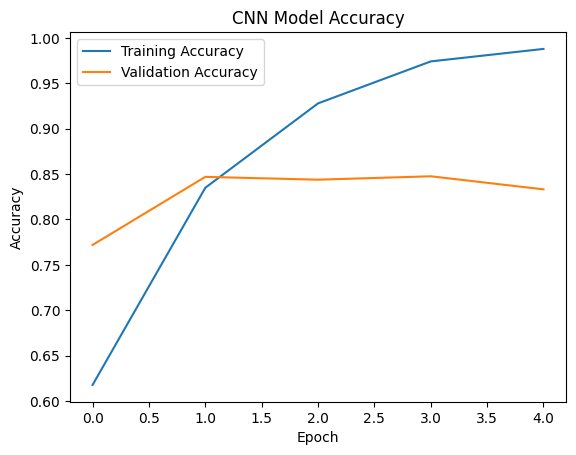

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## **Section 7 : Evaluation of Implementation**

---



The implemented Convolutional Neural Network (CNN) achieved a test accuracy of 83.5%, corresponding to an error rate of 16.4% on the task. This result is reasonably strong but is not as good as the paper’s reported performance, where the best seq-CNN configuration achieved an error rate of 8.39%, and their hybrid model (seq2-bown-CNN) of 7.67%.

Several factors may explain this difference. Firstly, the paper likely used a more extensive training process, including hyperparameter tuning, longer training, and larger models, whereas this implementation was trained for only five epochs with default parameters. Secondly, the paper employs parallel CNN architectures, which combine multiple convolutional branches, enhancing performance through complementary feature extraction. This recreation used a single Conv1D layer, resembling the more basic seq-CNN baseline.

Regardless of the limitations, the model shows strong macro-averaged F1 score (0.85) and stable precision and recall, indicating that both classes were classified fairly well. The training and validation curves show consistent learning but with possible overfitting.

Overall, this implementation performs the paper’s core approach and confirms its effectiveness, but additional tuning and architectural complexity would be needed to match the error rates reported in the original work. Moreover, better and tronger equipment would be necessary to make the work run smoothly.

In [52]:
#Evaluate the implementation using the same performance metric(s) as the selected paper.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_prob = model.predict(X_test_seq)
y_pred = (y_pred_prob > 0.5).astype("int32")

#Accuracy
accuracy = accuracy_score(y_test_seq, y_pred)
error_rate = (1 - accuracy) * 100

print(f"Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.2f}%")

#Precision, Recall, F1 (Macro)
precision = precision_score(y_test_seq, y_pred, average='macro')
recall = recall_score(y_test_seq, y_pred, average='macro')
f1 = f1_score(y_test_seq, y_pred, average='macro')

print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro):    {recall:.4f}")
print(f"F1 Score (Macro):  {f1:.4f}")

#Full classification report
print("\nClassification Report Paper Implementation:")
print(classification_report(y_test_seq, y_pred, target_names=["Negative", "Positive"]))


63/63 [==============================] - 4s 65ms/step
Accuracy: 0.8355
Error Rate: 16.45%
Precision (Macro): 0.8409
Recall (Macro):    0.8347
F1 Score (Macro):  0.8346

Classification Report Paper Implementation:
              precision    recall  f1-score   support

    Negative       0.80      0.90      0.85      1013
    Positive       0.88      0.77      0.82       987

    accuracy                           0.84      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.84      0.83      2000

